# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [4]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties

In [9]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-10/reduced/NGC3311/NGC3311_B.fits')
data = hdu['PRIMARY'].data

NameError: name 'fits' is not defined

In [6]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=11.85, vmax=13.0939)

NameError: name 'data' is not defined

In [7]:
#cut
from astropy.nddata import Cutout2D
position = (902, 1257)
size=(100,100)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=11.85, vmax=13.093)

NameError: name 'data' is not defined

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [8]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

In [1]:
# how does it look?
geometry = EllipseGeometry (x0=50, y0=40, sma=40, eps=0.6,pa=75*np.pi/180)
plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=11.85, vmax=13.093)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

NameError: name 'EllipseGeometry' is not defined

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [11]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [12]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,12.187864924559262,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5303938494175516,11.855297330192089,0.009209839661678319,0.20912964891598376,0.01885867418089235,84.6947918041,3.28794816629,0.3357803890710096,13,0,10,0
0.5834332343593068,11.816450868035206,0.010025406639158537,0.21122421902271135,0.019303484086543782,84.1434872264,2.96497636581,0.3346190450021897,13,0,10,0
0.6417765577952376,11.77426529388243,0.010942338017261417,0.21352034841212444,0.01928526022958993,83.5217156556,3.09465853991,0.33464066429002576,13,0,10,0
0.7059542135747613,11.728669577847253,0.011984496993559704,0.216373403775039,0.0192818496021156,82.8225502742,2.85366151117,0.3362296620102344,13,0,10,0
0.7765496349322375,11.67951283603498,0.013189379474656667,0.21976794530426644,0.019671270223080566,82.0341590339,3.43119768231,0.3399324534949518,13,0,10,0
0.8542045984254613,11.626802761454286,0.014649599546624243,0.22385208443517052,0.01894207455437845,81.0800458958,2.91519675512,0.3178953701831729,13,0,10,0
0.9396250582680075,11.55857369843677,0.015167074214767904,0.2126398650229936,0.016644051687175643,79.7166881793,2.68063584079,0.2777238544996696,13,0,10,0


Text(0,0.5,'Ellipticity')

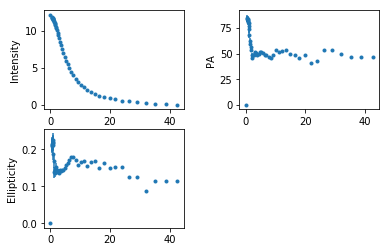

In [13]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [16]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower')
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower')
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower')
ax3.set_title('Residual')